# Monte Carlo Integration with Quasi Random Numbers

*This notebook first appeared as a [blog post](//betatim.github.io/posts/quasi-random-numbers) on [Tim Head](//betatim.github.io)'s blog.*

*License: [MIT](http://opensource.org/licenses/MIT)*

*(C) 2014, Tim Head.*
*Feel free to use, distribute, and modify with the above attribution.*

Everybody likes random numbers. They are so unpredictable! As it turns out though humans are not very good at appreciating true randomness. Even the kind that you get from a pseudo-random number generator that you can find in your favourite programming language.

This post is about how quasi random number sequences. One application for them is art, but another very useful one is solving numerical integrals (Quasi Monta Carlo integration).

Random numbers tend to "clump" together. This makes them look "non random" to use humans. If you flipped a coin several times in a row and recorded the results there would be more runs of tails (or heads) than  people would expect.

In [1]:
%matplotlib inline

In [2]:
import random
random.seed(34557)

results = []
for n in range(30):
    results.append(random.choice(["T", "H"]))
    
print("".join(results))

HTHTTTTHTTTHHHHHTHHTTTTHHTHTTH


Would you have expected as many HH or TT pairs as there are in this sequence? Would you have expected to see a run of 6 Ts?

What about numbers distributed across a square? Well, you would find they clump together:

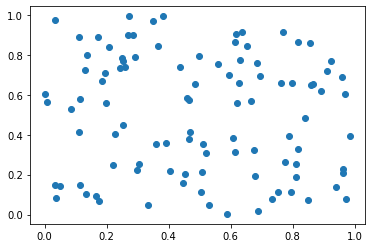

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(6345345)

# make 200 random numbers and use half as X coordinate
# and the other half as Y coordinate for 100 points
X = np.random.uniform(size=(100*2))
plt.scatter(X[:100], X[100:])

When people say "random" what they usually have in mind is "scattered around without a clear pattern and not clumped together". As a result when you need something that _looks_ random but does not have to _be_ random, you can turn to [Quasi random numbers](https://en.wikipedia.org/wiki/Low-discrepancy_sequence). The basic idea behind these types of sequences is that every time you draw a new point from them it is placed as far away from all points you already have as possible. The [Sobol sequence](https://en.wikipedia.org/wiki/Sobol_sequence) is a sequence of quasi random numbers in the range from 0 to 1. The first few draws from it are: 0, 1, 0.5 and 0.75. The first draw is palced at 0, the second one as far away as possible from 0 is at 1. The third draw, again being as far away as possible from all previous values lands at 0.5. And so on.

## Monte Carlo Integration ...
Besides being visually quite pleasing, there is one application in mathematics for which these quasi random numbers are very useful: doing integrals! The most popular method for solving integrals is [Monte Carlo integration](https://en.wikipedia.org/wiki/Monte_Carlo_integration). In Monte Carlo integration  the value of an integral is calculated by evaluating your function at random points and averaging the result over many iterations.

The value of the integral depends on the points at which you evaluate the function. In principle you get a different result every time you perform the integral.

At first this seems like a useless method. However you get an ever better approximation of the value of the integral the more points you sample at. This means you can run the integration for as long as you need to achieve the accuracy you are looking for.

## ... without the randomness!
One downside to using random numbers is that they are random, and that means they clump together! When doing an integral repeatedly evaluating the function at the same point does not help you at all. Even evaluating it again at a point nearby is a waste of time. What you want is to evaluate it at points you have not visited before. A point as far away from all previous points as possible. This is where the quasi random numbers come riding to the rescue!

Before we can actually prove that this works, some leg work is needed. Coding up a Sobol sequence is not that difficult but also not that much fun. Especially as someone has already done the job for us. You can find Sobol and friends in the [GSL](http://www.gnu.org/software/gsl/) under [Quasi-random sequences](http://www.gnu.org/software/gsl/manual/html_node/Quasi_002dRandom-Sequences.html#Quasi_002dRandom-Sequences). Using the GSL from python is straight forward thanks to:

## Cython

In [18]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


The [Cython](http://cython.org) magic of the IPython notebook makes it possible to write and compile Cython inside the notebook. Thus interfacing C libraries is easy. To call a simple function for calculating Bessel functions all you have to do is:

In [22]:

%reload_ext Cython

In [23]:
%%cython -l gsl
ok


Error compiling Cython file:
------------------------------------------------------------
...
ok
^
------------------------------------------------------------

/Users/mikhailgasanov/.ipython/cython/_cython_magic_41f58f7e0dfb29540af5a44bbdb6e8c4.pyx:1:0: undeclared name not builtin: ok


In [26]:
%%cython -l gsl

# %load_ext Cython -l gsl
# Include the right header file and declare the function
cdef extern from "gsl/gsl_sf_bessel.h":
    double gsl_sf_bessel_J0(double x)

# # small python wrapper to give it a nicer name
# def bessel_J0(double x):
#     return gsl_sf_bessel_J0(x)

# x = bessel_J0(2.21)
# x


Error compiling Cython file:
------------------------------------------------------------
...

%load_ext Cython -l gsl
^
------------------------------------------------------------

/Users/mikhailgasanov/.ipython/cython/_cython_magic_30bf5abba1c2b7c07b9911481d31ea13.pyx:2:0: Expected an identifier or literal


In [10]:
x

NameError: name 'x' is not defined

The Sobol sequence available in GSL is a bit more complicated than a simple function call. You have to first create a new quasi-random sequence, then you can access values from it by calling a function with a `double*` as argument which will then contain the values you asked for. Wrapping things in a small python class makes everything more convenient:

In [7]:
%%cython -l gsl
from cpython.mem cimport PyMem_Malloc, PyMem_Free

# Declare the few types and functions we need
cdef extern from "gsl/gsl_qrng.h":
    ctypedef struct gsl_qrng
    ctypedef struct gsl_qrng_type
    gsl_qrng_type* gsl_qrng_sobol
    
    gsl_qrng* gsl_qrng_alloc(gsl_qrng_type* T, unsigned int d)
    void gsl_qrng_free(gsl_qrng* q)
    
    int gsl_qrng_get(const gsl_qrng * q, double x[])

# This is the wrapper class
cdef class Sobol:
    cdef gsl_qrng* _q
    cdef unsigned _D
    cdef double *_v
    def __cinit__(self, D=1):
        """Create a `D` dimensional Sobol sequence."""
        self._D = D
        
        # gsl_qrng_get() returns the next
        # value in one of its arguments
        self._v = <double *>PyMem_Malloc(D * sizeof(double))
        if not self._v:
            raise MemoryError()
        
        # Actually allocate the QRNG generator
        self._q = gsl_qrng_alloc(gsl_qrng_sobol, D)
        if self._q is NULL:
            raise MemoryError()
        
    def get(self, int N=1):
        """The next `N` points in the sequence."""
        points = []
        for n in xrange(N):
            points.append(self.__next__())
            
        return points
        
    def __next__(self):
        """Iterate over the sequence."""
        gsl_qrng_get(self._q, self._v)
        return [self._v[i] for i in xrange(self._D)]
    
    def __iter__(self):
        return self
    
    # Make sure we free all the memory we allocated
    def __dealloc__(self):
        if self._q is not NULL:
            gsl_qrng_free(self._q)
            
        PyMem_Free(self._v)

Let's create our first Sobol sequence and look at the numbers that come out of it:

In [8]:
s = Sobol()

for n,x in enumerate(s):
    print "Sobol point", n, "is", x
    if n > 10:
        break

Sobol point 0 is [0.5]
Sobol point 1 is [0.75]
Sobol point 2 is [0.25]
Sobol point 3 is [0.375]
Sobol point 4 is [0.875]
Sobol point 5 is [0.625]
Sobol point 6 is [0.125]
Sobol point 7 is [0.1875]
Sobol point 8 is [0.6875]
Sobol point 9 is [0.9375]
Sobol point 10 is [0.4375]
Sobol point 11 is [0.3125]


Finally, we can compare how clumpy our Sobol sequence looks compared to a sequence of random numbers.

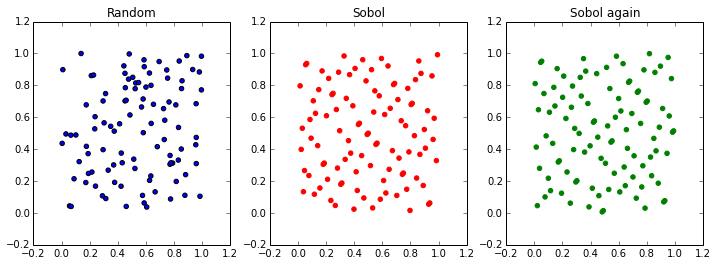

In [9]:
s2 = Sobol(2)

sobol_X, sobol_Y = zip(*s2.get(100))

sobol_X2 = (np.array(sobol_X) + np.random.uniform())%1
sobol_Y2 = (np.array(sobol_Y) + np.random.uniform())%1

X = np.random.uniform(size=(100*2))

f, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12,4))
ax1.scatter(X[:100], X[100:],)
ax2.scatter(sobol_X, sobol_Y, color="red")
ax3.scatter(sobol_X2, sobol_Y2, color="green")

ax1.set_title("Random")
ax2.set_title("Sobol")
ax3.set_title("Sobol again")

The red distribution of points looks like it has a lot less empty space than the blue one. Just as you would expect. The third plot shows what happens if you add random number to your Sobol sequence. For the moment just admire it and note that it still looks like a Sobol sequence.

## The proof is in the pudding

So now let's see if we can use this new technique to evaluate an integral. Instead of calculating the area of a circle like everyone else does the first time they learn about Monte Carlo integration, we will work out the area under a gaussian curve.

(<matplotlib.figure.Figure at 0x10cf81ad0>,
 <matplotlib.axes.AxesSubplot at 0x10e0d38d0>)

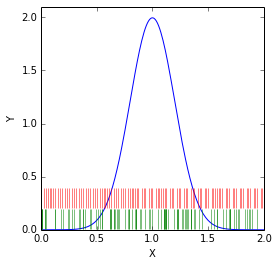

In [10]:
import scipy.stats as stats
_norm_pdf = stats.norm.pdf
def normal(x):
    return _norm_pdf(x, 1, 0.2)

def draw_gaus(samples=[]):
    X = np.linspace(0, 2, 200)
    Y = [normal(x) for x in X]
    
    f, ax = plt.subplots(figsize=(4,4))
    ax.plot(X, Y)
    ax.set_ylim([0.,2.1])
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    
    rug_y = 0.1
    for sample_points in samples:
        ax.plot(sample_points, [rug_y]*len(sample_points), '|', ms=20)
        rug_y += 0.2
        
    return f, ax

# Sample 100 points from a Sobol and a uniform sequence
# over the range 0 to 2.
s = Sobol()
sobol_samples = np.asarray(s.get(100))*2

random_samples = np.random.uniform(size=100)*2

draw_gaus([random_samples, sobol_samples])

On the figure you can see in blue the function $f(x)$ we want to integrate, in green are the points at which we will sample $f(x)$ in the standard Monte Carlo integration scheme, and in red the points at which we will sample the function in the Quasi Monte Carlo scheme.

You can already see that the red points are much more evenly distributed over the range. The green dashes tend to clump together and there are some regions which have no samples at all.

Basic Monte Carlo integration is a few lines of python. What we are doing is calculating the average of $f(x)$ at the sample points and multiplying by the length in $x$ over which we are integrating. We can also easily compute the uncertainty on the value of the integral. For the same function, the more times we evaluate the function the smaller the uncertainty on the integral.

In [11]:
def MC_integral(samples):
    L = 2.
    dx = L / len(samples)
    values = []
    for point in samples:
        values.append(normal(point))

    uncertainty = (L / np.sqrt(len(samples))) * np.std(values, ddof=1)
    return sum(values) * dx, uncertainty

Ok, go time! What is the area of a Gaussian? Considering we are using a function with PDF in the name you should be able to make a pretty good guess. Exactly, the area will be one. What does our Monte Carlo integration think?

In [12]:
print "Area: %.4f +- %.4f"%(MC_integral(np.random.uniform(size=100)*2))

Area: 1.0910 +- 0.1360


Using only 100 samples we get close to the real area of one, but the uncertainty is quite large. With this kind of uncertainty you should not be surprised if the result of a call to `MC_integral()` is 1.1 or 0.93. By increasing the number of samples the uncertainty will decrease.

In [13]:
for N in (100, 200, 400, 800, 1600):
    area, uncertainty = MC_integral(np.random.uniform(size=N)*2)
    print "%d samples, Area: %.4f +- %.4f"%(N, area, uncertainty)

100 samples, Area: 0.7280 +- 0.1196
200 samples, Area: 0.9734 +- 0.0948
400 samples, Area: 1.0281 +- 0.0698
800 samples, Area: 1.0113 +- 0.0482
1600 samples, Area: 0.9941 +- 0.0337


In order to decrease the uncertainty on the area by a factor of two, you have to quadruple the number of points at which you evaluate the integral. The uncertainty scales as $\frac{1}{\sqrt{N}}$. Quasi Monte Carlo integration promises to reduce the uncertainty faster than this.

Before we move on, two important questions you should ask yourself:

* do you trust the uncertainty estimate?
* is the estimate of the area unbiased?

Both of these can be checked by repeating the integration many times. By calculating the average differnece between the true area and the result of the intergration we can estimate the bias.

To establish whether or not our uncertainty estimate is correct we can take advantage of the fact that the result of the integration is different every time we call `MC_integral()` (for the same number of samples and same function). The calculated area will vary according to a gaussian distribution, and the width of that gaussian distribution is equal to the true uncertainty of the Monte Carlo integration.

The uncertainty calculated in `MC_integral()` is not used, so we can now compare the true uncertainty to the one we calculated. One way of doing this is to calculate the width of the distribution of $\frac{a_i - 1}{\sigma_i}$ over many repetitions of the calculation. Here $a_i$ and $\sigma_i$ are the area and uncertainty calculated by `MC_integral()` for the $i$th repetition. The resulting distribution should be centered on zero (if the calculation is unbiased) and have a width of one (if we estimated the uncertainty correctly).

In [14]:
def test_integration(sampler, integrator, repeats=2000):
    Is = []
    for n in xrange(repeats):
        points = sampler()
        Is.append(integrator(points))

    integrals, errors = zip(*Is)
    # we know that the area is one, so by subtracting
    # the true value and dividing by the calculated
    # uncertainty we should end up with a gaussian
    # distribution centered on zero and width one if we
    # did everything right
    bias = integrals - np.ones_like(integrals)
    pulls = bias / errors

    f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(8,8))
    ax1.hist(integrals, bins=20, range=(0.7,1.3))
    ax1.set_title("Area")

    ax2.hist(errors, bins=20, range=(np.min(errors)*0.8, np.max(errors)*1.2))
    ax2.set_title("Calcuated Uncertainty")

    ax3.hist(pulls, range=(-4,4), bins=20)
    ax3.set_title("Pull")

    ax4.hist(bias, bins=20)
    ax4.set_title("Bias")
    print "Bias: %.4f, average uncertainty: %.4f"%(np.mean(bias), np.mean(errors))
    # I hope I got the uncertainty on the width of the pull distribution right
    # Error on the error on the error on the error ...
    print "Width of pull distribution: %.4f+-%.5f"%(np.std(pulls),
                                                    np.std(pulls)/np.sqrt(2.*(len(pulls)-1)))
    return np.mean(errors)

Bias: -0.0000, average uncertainty: 0.1343
Width of pull distribution: 1.0119+-0.01600


0.13433707981829704

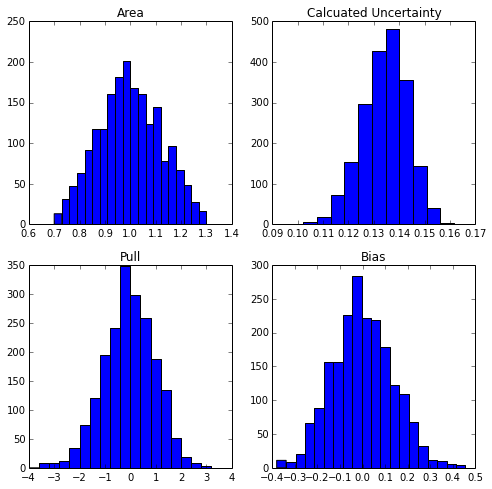

In [15]:
test_integration(lambda: np.random.uniform(size=100)*2,
                 MC_integral, repeats=4*500)

Each of the plots is a histogram of the results of the 2000 MC integrations we performed. In the top left plot you can see that the area varies every time you evaluate the integral. The top right plot shows the uncertainty calculated by the MC integrator for each evaluation. The bottom right shows the difference between the calculated area and the true area, and the bottom left shows the "pull". The pull is the bias divided by the calculated uncertainty.

The function also prints the width of the pull distribution, as you can see it is consistent with one. This means the uncertainty is calculated correctly.

How does the Sobol sequence do? It promises a smaller uncertainty for the same number of samples, or conversely less samples needed to achieve the same uncertainty.

Bias: 0.0000, average uncertainty: 0.1356
Width of pull distribution: 0.1739+-0.00275


0.13559523944641697

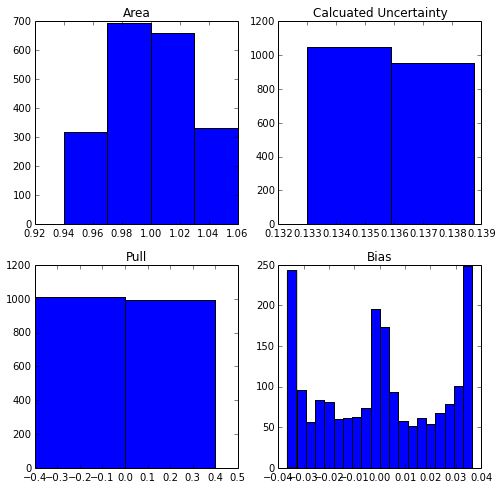

In [16]:
s = Sobol()
sobol_points = s.get(100)
# Two approaches to re-randomise the Sobol sequence that should
# allow for uncertainty estimates but do not. Try them yourself!
#sampler = lambda: ((np.asarray(sobol_points).ravel() + np.random.uniform())%1)*2
#sampler = lambda: ((np.asarray(s.get(100)).ravel() + np.random.uniform())%1)*2

sampler = lambda: np.asarray(s.get(100)).ravel()*2
test_integration(sampler, MC_integral, repeats=4*500)

This is where this post comes to an abrupt end. You can see from the above plots that the Quasi Monte Carlo integration does not seem to play well with estimating uncertainties. The calculated area is not a smoothly varying number but only one of a small set of values. This discreetness messes with all the other figures.

After some reading I found articles which recommend re-randomising the Sobol sequence by adding a random number to it. This does not seem to help. Maybe there is a mistake in my code here somewhere.

We have rediscovered one of the major problems with Quasi Monte Carlo integration: estimating the uncertainty is hard. While theoretically the uncertainty should be smaller, evaluating what it actually is on a case by case basis is very difficult.

## PS. errors on errors
>If you are not a big fan of evaluating uncertainties you can go now

How well we can estimate the width of the pull distribution depends on
the number of repeats, not the number of samples used to do the integration

Bias: 0.0050, average uncertainty: 0.1350
Width of pull distribution: 1.0097+-0.02259


0.13504112817337668

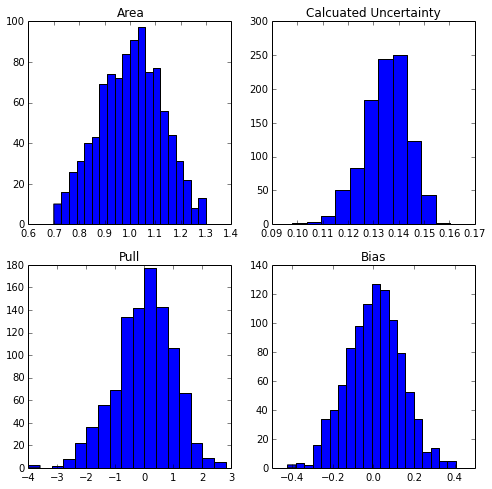

In [17]:
test_integration(lambda: np.random.uniform(size=100)*2,
                 MC_integral, repeats=2*500)

Bias: 0.0033, average uncertainty: 0.0954
Width of pull distribution: 0.9869+-0.02208


0.095412335925863193

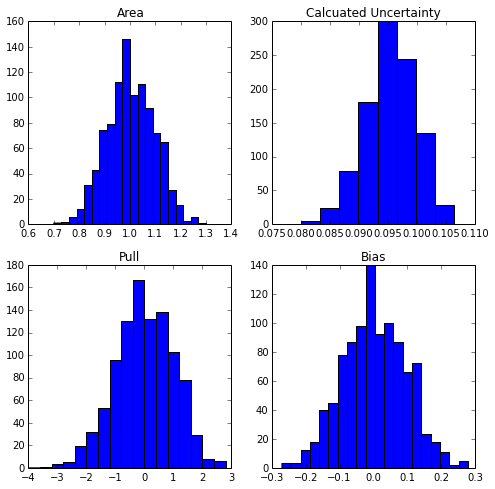

In [18]:
# How well we can estimate the width of the pull distribution depends on
# the number of repeats, not the number of samples
test_integration(lambda: np.random.uniform(size=200)*2,
                 MC_integral, repeats=2*500)